In [15]:
# Import necessary libraries
import torch
import numpy as np
import random

# Set random seed for reproducibility
seed = 42  # You can change this number, but it should be the same across all runs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Optionally, set the random seed for CUDA (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Now import other libraries after setting the random seed
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve


In [16]:
# Import necessary libraries
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import numpy as np

# Load PubMed Dataset
dataset_name = 'PubMed'
dataset = Planetoid(root=f'data/{dataset_name}', name=dataset_name, transform=NormalizeFeatures())

# Access the data object
data = dataset[0]

# Inspect dataset
print(f"Dataset: {dataset_name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Train Mask: {data.train_mask.sum()} nodes")
print(f"Test Mask: {data.test_mask.sum()} nodes")

# Step 2: Adjust the split ratio
split_ratio = 0.8  # 80% for target dataset, 20% for shadow dataset

# Get all the indices (train + test + validation)
all_indices = torch.arange(data.num_nodes)

# Shuffle the indices to randomize the split
shuffled_indices = all_indices[torch.randperm(all_indices.size(0))]

# Calculate the split index
num_target = int(len(shuffled_indices) * split_ratio)
num_shadow = len(shuffled_indices) - num_target

# Split into target and shadow
target_indices = shuffled_indices[:num_target]
shadow_indices = shuffled_indices[num_target:]

# Create the target and shadow masks
target_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
target_mask[target_indices] = True

shadow_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
shadow_mask[shadow_indices] = True

# Update the masks for target and shadow datasets
data.target_mask = target_mask
data.shadow_mask = shadow_mask

# Inspect the split
print(f"Target dataset: {target_mask.sum()} nodes")
print(f"Shadow dataset: {shadow_mask.sum()} nodes")


Dataset: PubMed
Number of nodes: 19717
Number of edges: 88648
Number of features: 500
Number of classes: 3
Train Mask: 60 nodes
Test Mask: 1000 nodes
Target dataset: 15773 nodes
Shadow dataset: 3944 nodes


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # First GCN layer
        self.conv2 = GCNConv(16, num_classes)  # Second GCN layer (output layer)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)  # First GCN layer
        x = F.relu(x)  # Apply ReLU activation
        x = F.dropout(x, training=self.training)  # Apply dropout
        x = self.conv2(x, edge_index)  # Second GCN layer
        return F.log_softmax(x, dim=1)  # Apply log_softmax for classification

# Initialize the model
model = GCN(data.num_features, dataset.num_classes)

# Train the GNN model on the target dataset
def train_model(model, data, epochs=200, lr=0.001):
    model.train()  # Set the model to training mode
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    for epoch in range(epochs):
        optimizer.zero_grad()  # Zero out the gradients
        out = model(data)  # Forward pass
        
        # Compute loss (nll_loss for classification)
        loss = F.nll_loss(out[data.target_mask], data.y[data.target_mask])
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Print progress
        if epoch % 10 == 0:
            acc = test_model(model, data)  # Evaluate the model
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

# Test function (evaluating accuracy)
def test_model(model, data):
    model.eval()  # Set the model to evaluation mode
    out = model(data)
    pred = out.argmax(dim=1)  # Get predictions
    correct = (pred[data.target_mask] == data.y[data.target_mask]).sum()
    accuracy = int(correct) / int(data.target_mask.sum())  # Calculate accuracy
    return accuracy

# Initialize the GCN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=data.num_features, num_classes=dataset.num_classes).to(device)
data = data.to(device)

# Train the model on the target dataset
train_model(model, data, epochs=200, lr=0.001)


Epoch 0, Loss: 1.0989, Accuracy: 0.4024
Epoch 10, Loss: 1.0864, Accuracy: 0.5033
Epoch 20, Loss: 1.0730, Accuracy: 0.5365
Epoch 30, Loss: 1.0600, Accuracy: 0.5565
Epoch 40, Loss: 1.0474, Accuracy: 0.5828
Epoch 50, Loss: 1.0353, Accuracy: 0.6095
Epoch 60, Loss: 1.0235, Accuracy: 0.6259
Epoch 70, Loss: 1.0119, Accuracy: 0.6350
Epoch 80, Loss: 1.0003, Accuracy: 0.6398
Epoch 90, Loss: 0.9888, Accuracy: 0.6453
Epoch 100, Loss: 0.9771, Accuracy: 0.6559
Epoch 110, Loss: 0.9651, Accuracy: 0.6699
Epoch 120, Loss: 0.9530, Accuracy: 0.6855
Epoch 130, Loss: 0.9409, Accuracy: 0.7028
Epoch 140, Loss: 0.9289, Accuracy: 0.7198
Epoch 150, Loss: 0.9169, Accuracy: 0.7347
Epoch 160, Loss: 0.9050, Accuracy: 0.7481
Epoch 170, Loss: 0.8931, Accuracy: 0.7574
Epoch 180, Loss: 0.8814, Accuracy: 0.7653
Epoch 190, Loss: 0.8699, Accuracy: 0.7726


Target Dataset AUC: 0.9111


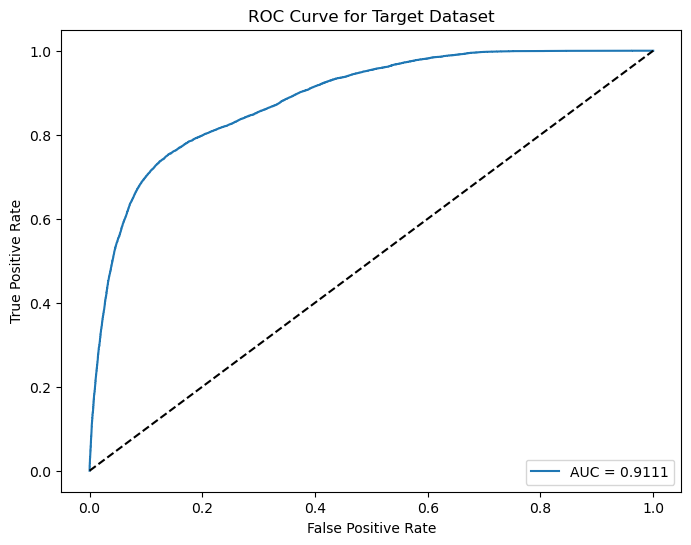

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Function to one-hot encode the labels
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]

# Plotting AUC Curve and Evaluating Model
def plot_auc_curve(model, data):
    model.eval()  # Set the model to evaluation mode
    out = model(data)  # Forward pass (output logits)

    # Apply Softmax to get class probabilities
    probs = F.softmax(out, dim=1)  # Convert logits to probabilities

    # Get predictions and true labels for the target dataset
    preds = probs[data.target_mask].cpu().detach().numpy()  # Predicted probabilities
    labels = data.y[data.target_mask].cpu().detach().numpy()  # True labels

    # One-hot encode the true labels
    labels_one_hot = one_hot_encode(torch.tensor(labels), num_classes=dataset.num_classes).cpu().detach().numpy()

    # Calculate AUC score using roc_auc_score (requires probabilities)
    auc = roc_auc_score(labels_one_hot, preds, multi_class='ovr', average='macro')
    print(f"Target Dataset AUC: {auc:.4f}")

    # Plot ROC Curve for multi-class (use max probability for ROC)
    fpr, tpr, thresholds = roc_curve(labels_one_hot.ravel(), preds.ravel())  # Flatten for ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Target Dataset')
    plt.legend(loc='lower right')
    plt.show()

# Example: After training, call this function to evaluate the model
plot_auc_curve(model, data)
